### Libraries

In [146]:
!pip install lime

In [147]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import seaborn as sns
import numpy as np
from lime import lime_tabular
import shap

### Reading & preprocessing data

In [148]:
df = pd.read_csv("df_cleaned.csv")
df.head()

,last_pymnt_d,total_rec_prncp,last_pymnt_amnt,out_prncp,total_rec_late_fee,last_fico_range_high,installment,loan_amnt,total_rec_int,out_prncp_inv,...,funded_amnt_inv,recoveries,debt_settlement_flag,hardship_flag,mo_sin_old_rev_tl_op,revol_util,dti,all_util,annual_inc,loan_status
0,17,-0.332581,-0.372797,0.420080,-0.261895,0.281611,-0.473027,-0.461473,0.413942,0.420298,...,-0.461004,-0.445598,0,0,-0.307356,0.608376,0.558953,0.915820,-1.203816,0
1,31,-0.840560,-0.473603,-0.629220,-0.261895,1.244049,-1.608631,-1.601510,-1.081823,-0.629167,...,-1.601271,-0.445598,0,0,-0.187187,-1.880835,-1.233491,-0.049124,0.274631,1
2,27,-0.250720,-0.222228,2.263937,-0.261895,0.883135,1.252073,1.058575,-0.380182,2.264445,...,1.059353,-0.445598,0,0,-0.980297,0.431193,-0.223328,0.379740,2.227297,1
3,39,-0.458023,0.161605,-0.629220,-0.261895,0.161306,-1.364264,-1.373503,-0.909433,-0.629167,...,-1.373218,-0.445598,0,0,-1.472987,0.314511,-0.337836,0.433348,-1.231711,1
4,5,-0.415519,0.220569,-0.629220,-0.261895,0.221459,-1.317547,-1.348168,-0.834440,-0.629167,...,-1.347878,-0.445598,0,0,0.738107,1.273894,0.117928,1.559116,-0.841178,1


In [149]:
X = df.drop("loan_status", axis = 1)
y = df["loan_status"]

In [150]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=737)

### Decision Tree Model

In [151]:
def decision_tree_model(x_train, y_train, criterion="gini", max_depth=5, max_features=0.8,
                        max_leaf_nodes=None, min_samples_leaf=7, min_samples_split=3,
                        min_weight_fraction_leaf=0):
  """
  Creates & trains a Decision Tree Classifier on given training data.

  Args:
  ----------
  x_train : array-like or pandas DataFrame
      Training input samples.
  y_train : array-like
      Target values (class labels) corresponding to x_train.
  criterion : str, default="gini"
      The function to measure the quality of a split. Supported criteria are "gini" for the Gini impurity
      and "entropy" for the information gain.
  max_depth : int, default=5
      The maximum depth of the tree. If None, nodes are expanded until all leaves are pure.
  max_features : int, float, or {"sqrt", "log2"}, default=0.8
      The number of features to consider when looking for the best split.
      If float, it represents a fraction of the total number of features.
  max_leaf_nodes : int, default=None
      Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity.
      If None, then unlimited number of leaf nodes.
  min_samples_leaf : int, default=7
      The minimum number of samples required to be at a leaf node.
  min_samples_split : int, default=3
      The minimum number of samples required to split an internal node.
  min_weight_fraction_leaf : float, default=0
      The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node.

  Returns:
  -------
  dt : DecisionTreeClassifier
      The trained Decision Tree Classifier model.
  """
  dt = tree.DecisionTreeClassifier(criterion = criterion, max_depth = max_depth,
                                   max_features = max_features, max_leaf_nodes = max_leaf_nodes,
                                   min_samples_leaf = min_samples_leaf,
                                   min_samples_split = min_samples_split,
                                   min_weight_fraction_leaf = min_weight_fraction_leaf)
  dt.fit(x_train, y_train)
  return dt

In [152]:
dt = decision_tree_model(x_train, y_train)

In [153]:
y_pred_dt = dt.predict(x_test)

### Performance Measures

In [154]:
accuracy_score(y_test, y_pred_dt)

0.9673903931595272

In [155]:
f1_score(y_test, y_pred_dt)

0.9688999040614007

In [156]:
roc_auc_score(y_test, dt.predict_proba(x_test)[:, 1])

np.float64(0.9855803039451501)

### Interpretability

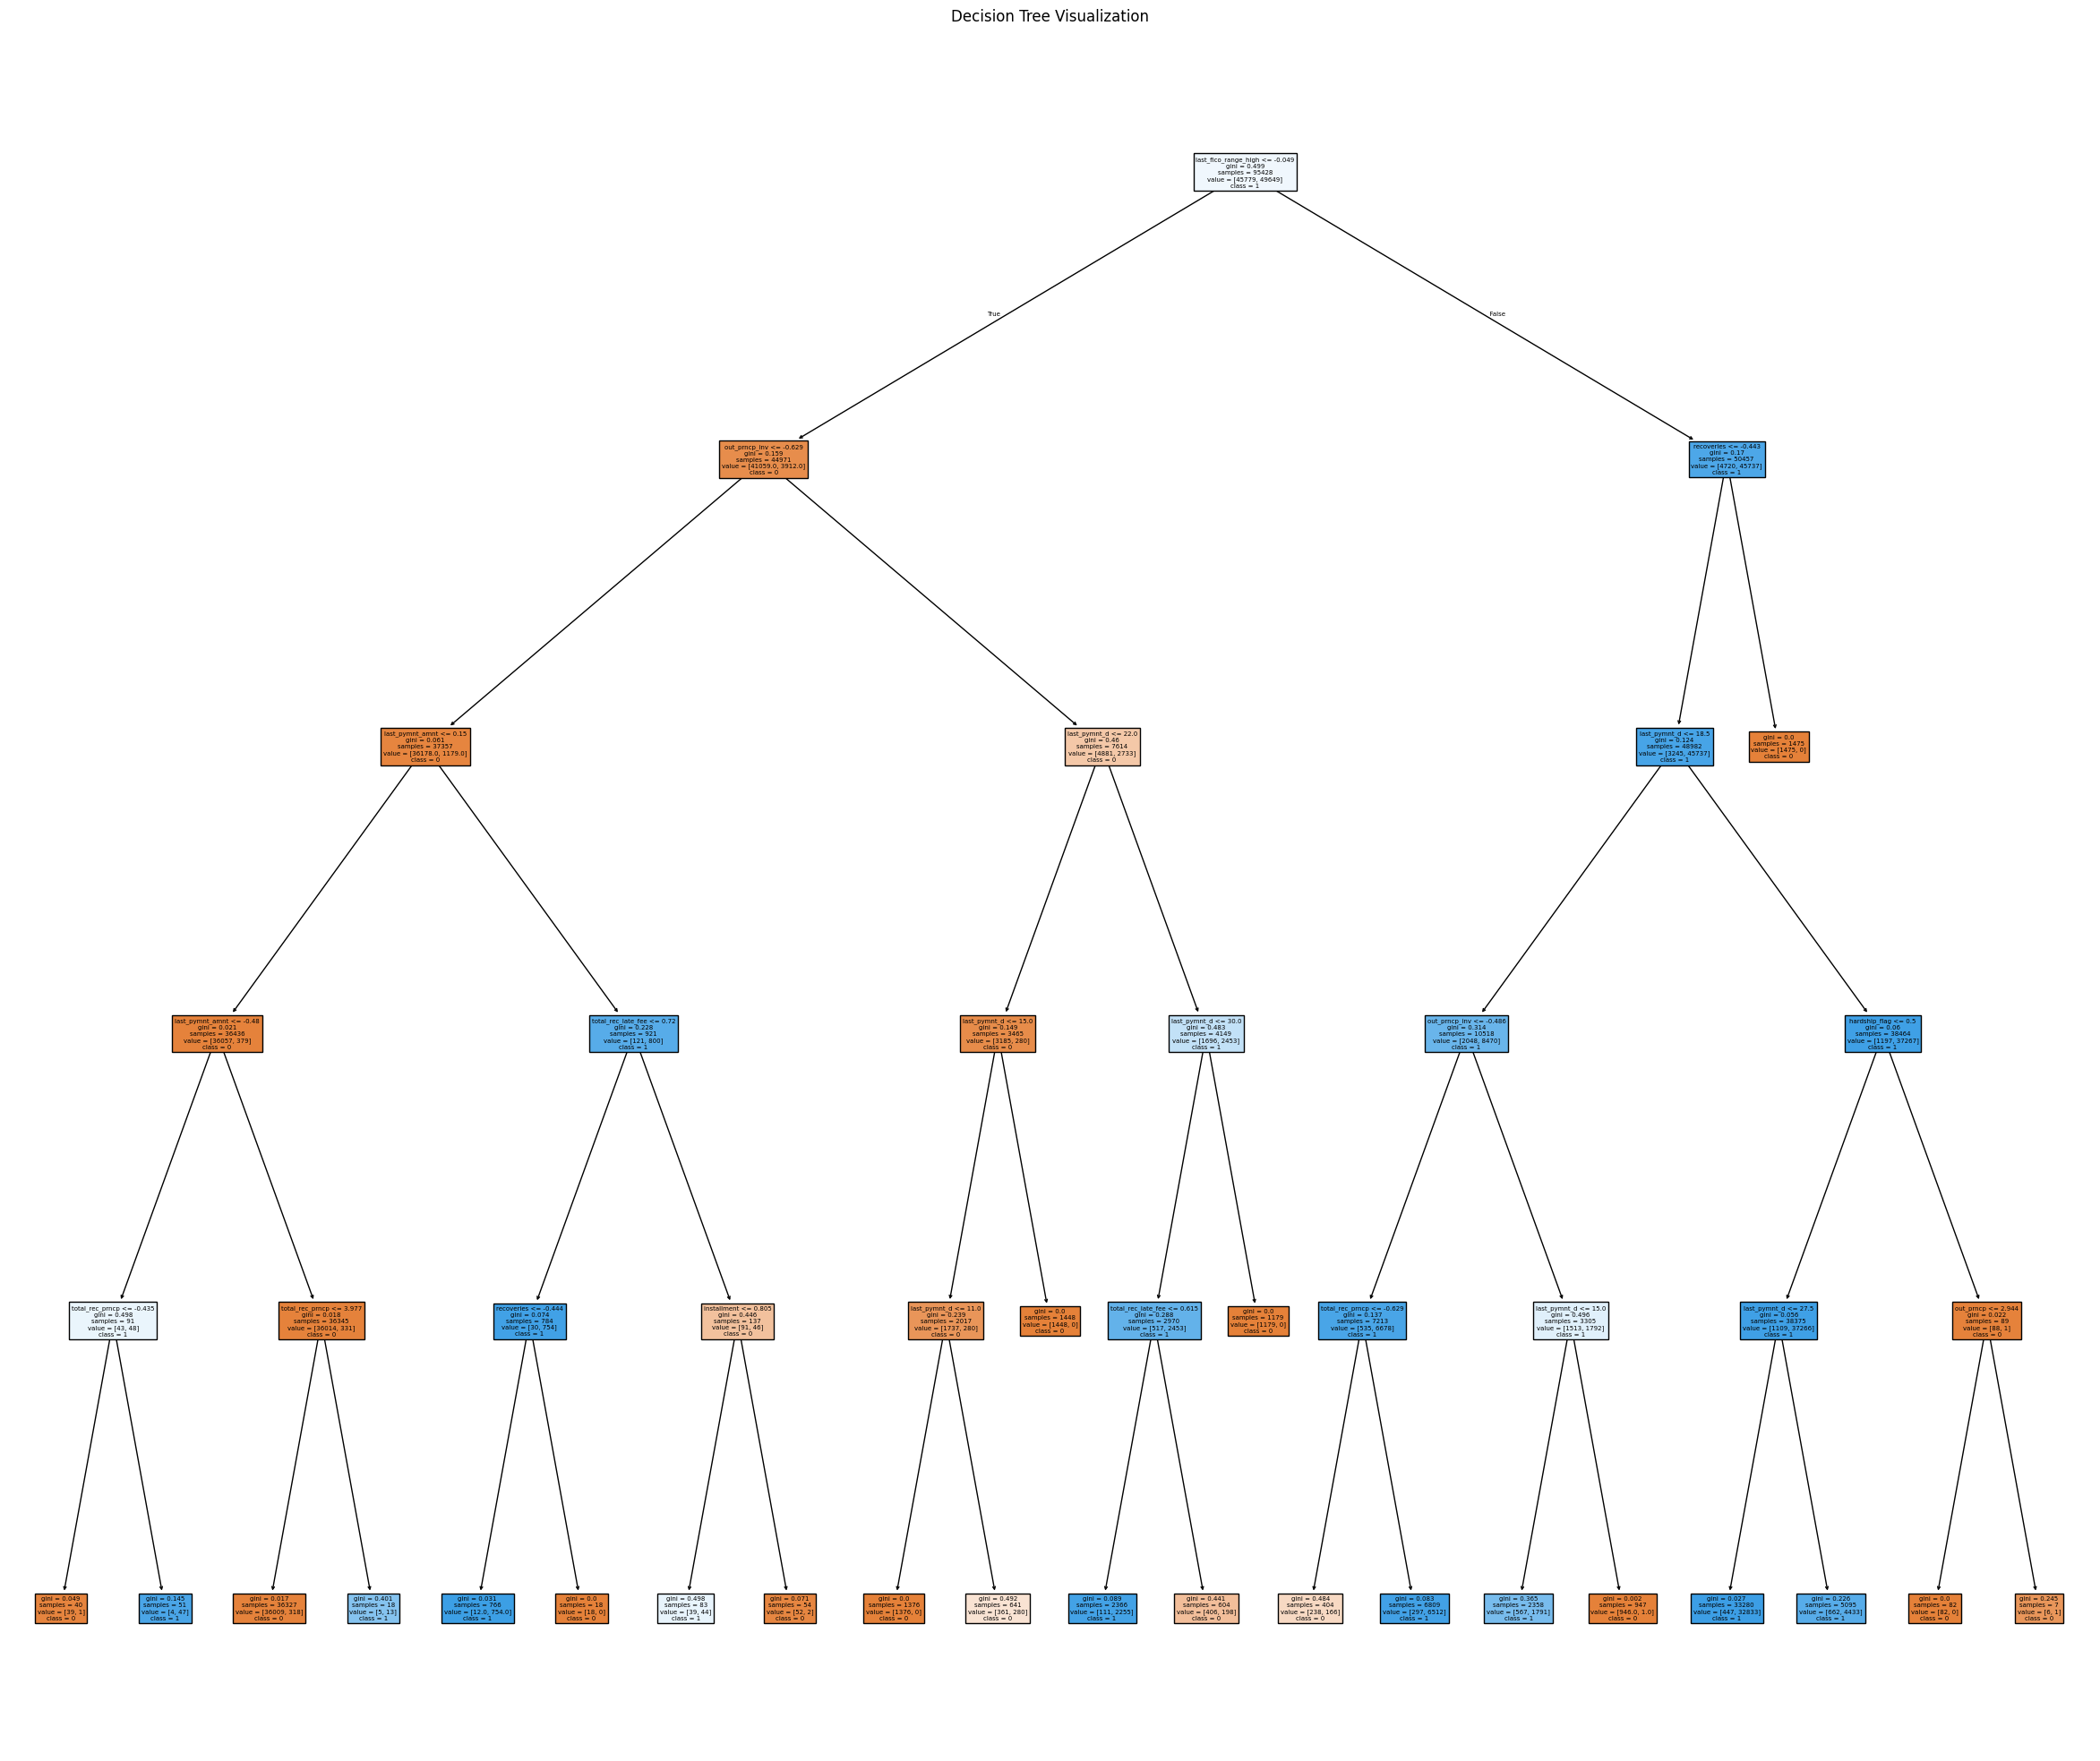

In [157]:
plt.figure(figsize=(30, 25))
plot_tree(dt, feature_names=X.columns, class_names=["0", "1"], filled=True)
plt.title('Decision Tree Visualization')
plt.show()

### Explainability

#### ICE

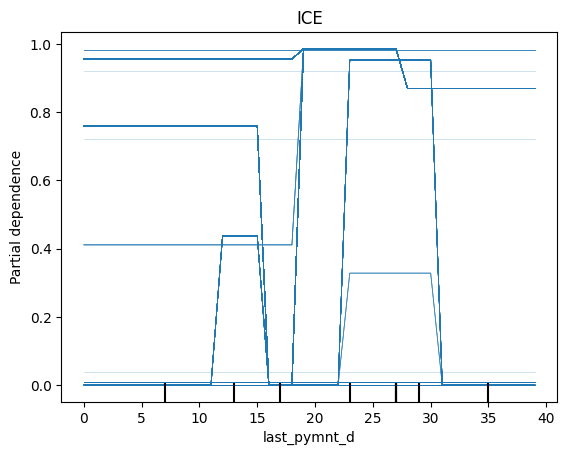

In [158]:
feature = [0]
PartialDependenceDisplay.from_estimator(dt, x_test, features=feature, target=1, kind='individual')
plt.title("ICE")
plt.show()

Different instances are grouped in different lines. Leaving some values more important than others.

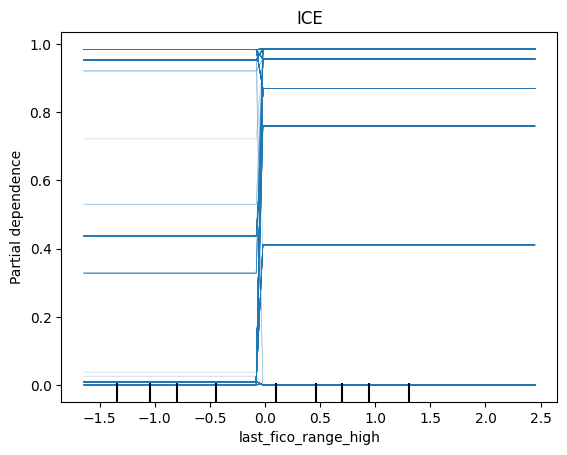

In [159]:
feature = [5]
PartialDependenceDisplay.from_estimator(dt, x_test, features=feature, target=1, kind='individual')
plt.title("ICE")
plt.show()

Different instances are grouped in different lines. Leaving some values more important than others.

#### LOFO

In [160]:
accuracies = []
f1_scores = []
roc_aucs = []
cols = x_train.columns.tolist()
for col in cols:
  xtrain = x_train.drop(col, axis=1)
  xtest = x_test.drop(col, axis=1)

  dt = decision_tree_model(xtrain, y_train)
  y_pred = dt.predict(xtest)
  accuracies.append(accuracy_score(y_test, y_pred))
  f1_scores.append(f1_score(y_test, y_pred))
  roc_aucs.append(roc_auc_score(y_test, y_pred))


dt = decision_tree_model(x_train, y_train)
y_pred = dt.predict(x_test)
accuracies.append(accuracy_score(y_test, y_pred))
f1_scores.append(f1_score(y_test, y_pred))
roc_aucs.append(roc_auc_score(y_test, y_pred))
cols.append("None")

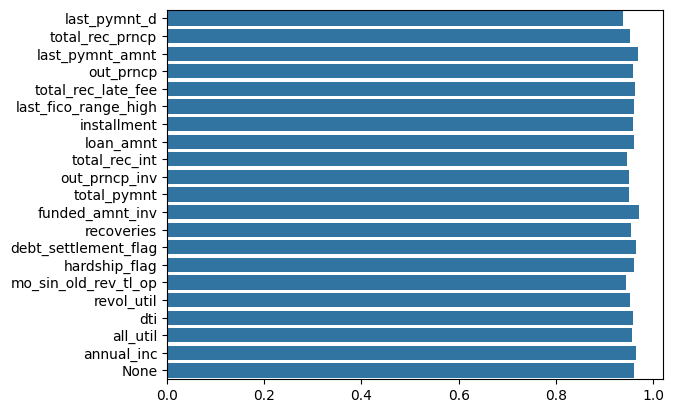

In [161]:
sns.barplot(y=cols, x=accuracies)
plt.show()

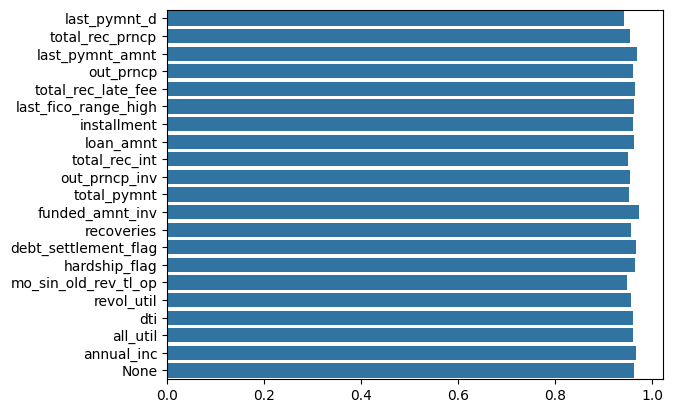

In [162]:
sns.barplot(y=cols, x=f1_scores)
plt.show()

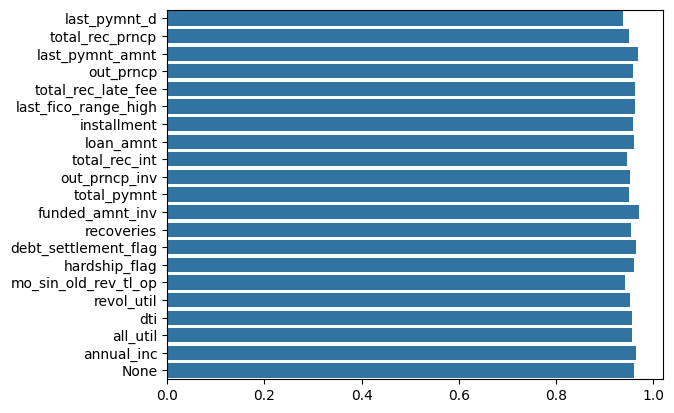

In [163]:
sns.barplot(y=cols, x=roc_aucs)
plt.show()

All features have very marginal differences across all performance measures.

Meaning all features are needed for proper classification.

#### LIME

In [165]:
x_test.reset_index(inplace=True)
x_test.drop("index", axis=1, inplace=True)
# x_test.drop("level_0", axis=1, inplace=True)
# x_test.head()
x_test.shape

(23858, 20)

In [166]:
instance = x_test.iloc[0]

explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(x_train),
                                              mode='classification',
                                              feature_names=x_train.columns.tolist())

def predfunc(instance):
  return dt.predict_proba(instance)

values = explainer.explain_instance(instance, predfunc, num_samples=1000,
                                              num_features=x_train.shape[1])
values.as_list()

/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

[('16.00 < last_pymnt_d <= 27.00', 0.28288429246172586),
 ('last_fico_range_high > 0.82', -0.2746696843416476),
 ('total_rec_late_fee <= -0.26', 0.11667707922853318),
 ('total_rec_int > 0.40', 0.041503843885174294),
 ('hardship_flag <= 0.00', 0.04051404225706583),
 ('debt_settlement_flag <= 0.00', -0.036218143837765386),
 ('total_rec_prncp > 0.38', 0.02862941056033364),
 ('recoveries <= -0.45', 0.020974081876745772),
 ('total_pymnt > 0.49', -0.01696677592003943),
 ('out_prncp > 0.42', -0.01645212092539195),
 ('-0.07 < dti <= 0.69', 0.014628624088459248),
 ('revol_util > 0.73', -0.01450867002911477),
 ('out_prncp_inv > 0.42', -0.014420561848848221),
 ('installment > 0.53', -0.014156507660575144),
 ('loan_amnt > 0.65', -0.013045944154967072),
 ('-0.33 < last_pymnt_amnt <= -0.22', 0.010655383865352374),
 ('0.06 < all_util <= 0.70', -0.009957837346058008),
 ('annual_inc > 0.41', -0.0022451435224855386),
 ('-0.70 < mo_sin_old_rev_tl_op <= -0.15', -0.0016924204485503677),
 ('funded_amnt_inv 

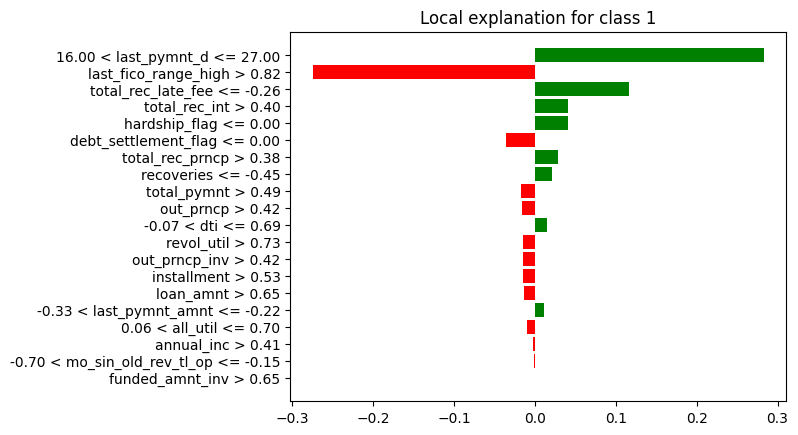

In [167]:
values.as_pyplot_figure();

last_pymnt_d affects the point the most positively.

last_fico_range_high affects the point the most negatively.

all_util has the least effect on the point.

In [168]:
instance = x_test.iloc[500]

explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(x_train),
                                              mode='classification',
                                              feature_names=x_train.columns.tolist())

def predfunc(instance):
  return dt.predict_proba(instance)

values = explainer.explain_instance(instance, predfunc, num_samples=1000,
                                              num_features=x_train.shape[1])
values.as_list()

/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

[('-0.92 < last_fico_range_high <= 0.10', 0.24357601323350528),
 ('last_pymnt_d > 27.00', -0.1966676861484219),
 ('hardship_flag <= 0.00', 0.18189535546295615),
 ('total_rec_late_fee <= -0.26', 0.13233189593249237),
 ('debt_settlement_flag <= 0.00', -0.10186228755687658),
 ('all_util <= -0.64', 0.029231952980124855),
 ('out_prncp <= -0.63', -0.029023818313835485),
 ('revol_util <= -0.75', -0.025554637119461664),
 ('-0.70 < installment <= -0.23', -0.023855678094237227),
 ('-0.15 < mo_sin_old_rev_tl_op <= 0.53', 0.022930472060549288),
 ('recoveries <= -0.45', 0.01992762965851231),
 ('-0.07 < dti <= 0.69', -0.018110994777094516),
 ('-0.39 < last_pymnt_amnt <= -0.33', 0.016378787250447488),
 ('-0.71 < loan_amnt <= -0.21', -0.008881503650265464),
 ('-0.72 < total_rec_prncp <= -0.34', 0.0078535015541802),
 ('-0.75 < total_pymnt <= -0.27', -0.007438951490885085),
 ('-0.72 < total_rec_int <= -0.33', -0.006186746817042875),
 ('out_prncp_inv <= -0.63', -0.002966753667246529),
 ('-0.23 < annual_i

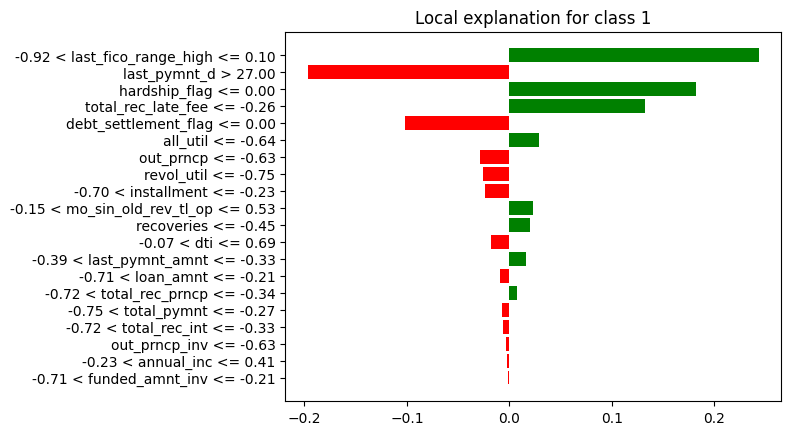

In [169]:
values.as_pyplot_figure();

last_fico_range_high affects the point the most positively.

last_pymnt_d affects the point the most negatively.

last_pymnt_amnt has the least effect on the point.

#### SHAP

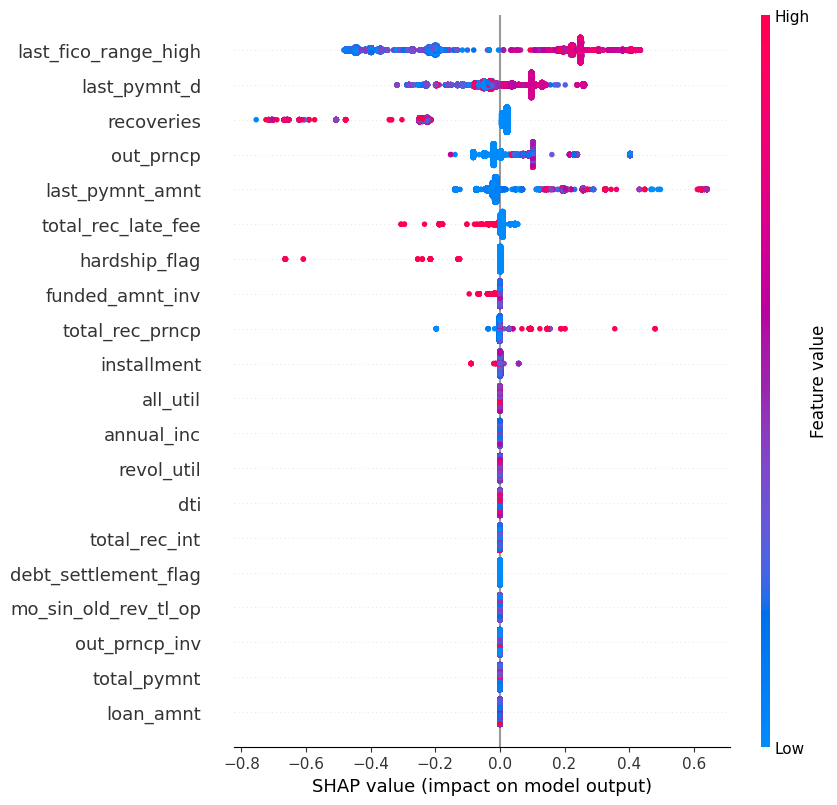

In [170]:
explainer = shap.TreeExplainer(dt)
explanation = explainer(x_test)
shap_values = explainer(x_test)
shap.plots.beeswarm(shap_values[:, :, 1], group_remaining_features=False, max_display=20)

all_util, annual_inc, revol_util, dti, total_rec_int, debt_settlement_flag, mo_sin_old_rev_Tl_op, out_prncp_inv, totl_pymnt, loan_amnt: All have very small impact on the model.

All other columns affect the model in positive and negative ways with varying degrees.